In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import scipy as sp
from ipumspy import readers, ddi

Load the `KIDPAN_DATA` file, attaching the appropriate column names. Restrict data to kidney donations (exclude kidney-pancreas, kidney-heart, etc.).

In [3]:
included_rows = [
    0, # WL_ORG
    54, # INIT_AGE
    61, # INIT_DATE
    118, # TX_DATE
    67, # DAYSWAIT_ALLOC
    52, # DAYSWAIT_CHRON
]
kidpan_data = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Delimited Text File 202312/Kidney_ Pancreas_ Kidney-Pancreas/KIDPAN_DATA.DAT",
    sep="\t",
    usecols=included_rows
)
colnames = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Analysis/KIDPAN_DATA_colnames.csv",
    sep=",",
    header=0,
    skiprows=lambda x : x-1 not in included_rows + [-1]
)
kidpan_data.columns = list(colnames["LABEL"])
kidpan_data = kidpan_data[kidpan_data["WL_ORG"] == "KI"]

C:\Users\brand\AppData\Local\Temp\ipykernel_30260\3734057989.py:9: DtypeWarning: Columns (52,54,67) have mixed types. Specify dtype option on import or set low_memory=False.
  kidpan_data = pd.read_csv(


In [4]:
kidpan_data["INIT_AGE"] = kidpan_data["INIT_AGE"].replace(".", np.nan).astype(float)
kidpan_data["INIT_DATE"] = pd.to_datetime(kidpan_data["INIT_DATE"].replace(".", np.nan))

# Characterizing the age distribution

Text(0.5, 0, 'Age')

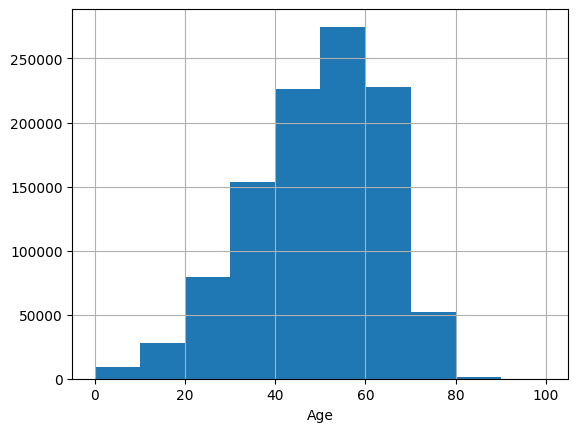

In [4]:
ages = kidpan_data["INIT_AGE"]
ax = ages.hist(bins=np.arange(0,np.max(ages)+10,10))
ax.set_xlabel("Age")

There appears to be an increase in the average initial age of people joining the waitlist over time

In [5]:
kidpan_data["years_since_first"] = (kidpan_data["INIT_DATE"] - kidpan_data["INIT_DATE"].min()).dt.days / 365
age_date_model = smf.ols(formula="INIT_AGE ~ years_since_first", data=kidpan_data, missing="drop")
results = age_date_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               INIT_AGE   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 5.285e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:24:47   Log-Likelihood:            -4.2947e+06
No. Observations:             1051851   AIC:                         8.589e+06
Df Residuals:                 1051849   BIC:                         8.589e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            36.1535      0.05

In [170]:
quantile_model = smf.quantreg("INIT_AGE ~ years_since_first", data=kidpan_data, missing="drop")
for q in [0.25,0.5,0.75]:
    quantile_results = quantile_model.fit(q=q)
    print(f"Quantile {q}:")
    print(quantile_results.summary())
    print()

Quantile 0.25:
                         QuantReg Regression Results                          
Dep. Variable:               INIT_AGE   Pseudo R-squared:              0.02486
Model:                       QuantReg   Bandwidth:                      0.6127
Method:                 Least Squares   Sparsity:                        55.21
Date:                Tue, 02 Apr 2024   No. Observations:              1051851
Time:                        16:46:08   Df Residuals:                  1051849
                                        Df Model:                            1
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            25.7624      0.098    263.904      0.000      25.571      25.954
years_since_first     0.3566      0.002    147.547      0.000       0.352       0.361

Quantile 0.5:
                         QuantReg Regression Results                     

C:\Users\brand\AppData\Local\Temp\ipykernel_3752\121962049.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_groupings = kidpan_data.groupby(


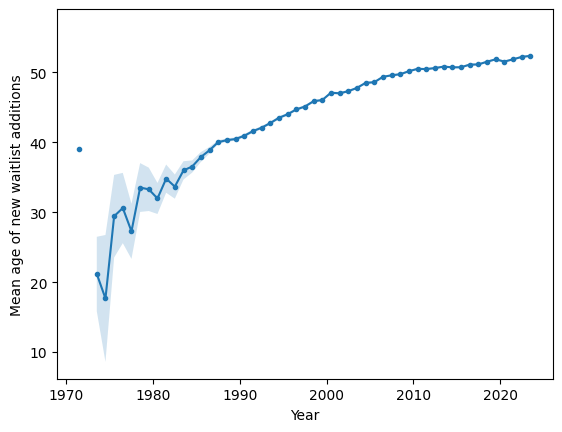

In [171]:
# Group by 'years_since_first' with bin size 1 and calculate mean of 'INIT_AGE'
year_groupings = kidpan_data.groupby(
    pd.cut(
        kidpan_data['years_since_first'],
        bins=np.arange(kidpan_data['years_since_first'].min(), kidpan_data['years_since_first'].max() + 1, 1)
    ),
    dropna=True
)
age_means = year_groupings.mean(numeric_only=True)
age_stes = year_groupings.sem(numeric_only=True)

# Plotting
plt.plot(age_means.index.categories.mid + 1970, age_means['INIT_AGE'], marker='.', linestyle='-')
plt.fill_between(
    age_means.index.categories.mid + 1970,
    age_means['INIT_AGE'] - age_stes['INIT_AGE']*1.96,
    age_means['INIT_AGE'] + age_stes['INIT_AGE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Mean age of new waitlist additions')
plt.show()

0.000166785759866191 -44.04161863602698 11.756124093514366


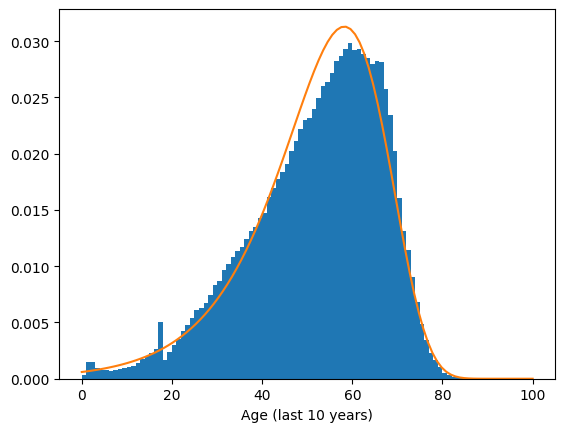

In [6]:
# plot histogram for ages from last 10 years
ages_last10 = np.array(kidpan_data["INIT_AGE"][kidpan_data["INIT_DATE"].dt.year >= 2013])
# correct for discontinuity at 17-19
# mean_count = np.sum((ages_last10 >= 17) * (ages_last10 <= 19)) // 3
# ages_last10 = ages_last10[(ages_last10 < 17) | (ages_last10 > 19)]
# ages_last10 = np.concatenate([
#     ages_last10,
#     np.ones(mean_count)*17,
#     np.ones(mean_count)*18,
#     np.ones(mean_count)*19,
# ])
# plot histogram
plt.hist(ages_last10, bins=np.arange(0,np.max(ages_last10)+1,1), density=True)
plt.xlabel("Age (last 10 years)")

# plot skewnorm fit for ages from last 10 years
x = np.linspace(0,100,100)
age_c, age_loc, age_scale = sp.stats.gompertz.fit(ages_last10)
print(age_c, age_loc, age_scale)
p = sp.stats.gompertz.pdf(x, age_c, age_loc, age_scale)
plt.plot(x,p)
plt.show()

In [7]:
# get general population data
nhis_data = readers.read_microdata(
    ddi=readers.read_ipums_ddi("C:/Users/brand/Desktop/STAR_Delimited/IPUMS Population Data/nhis_00001.dat/nhis_00001.xml"),
    filename="C:/Users/brand/Desktop/STAR_Delimited/IPUMS Population Data/nhis_00001.dat/nhis_00001.dat"
)
nhis_data.head()

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipumspy\readers.py:49: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


,YEAR,SERIAL,NUMPREC,STRATA,PSU,NHISHID,HHWEIGHT,REGION,PERNUM,NHISPID,...,HISPETH,EDUC,INCFAM07ON,POVERTY,HEIGHT,WEIGHT,HINOTCOVE,HEPATEV,HYPERTENEV,DIABTYPE
0,2013,1,5,6079,1,00002013000001,3406,2,1,0020130000010101,...,10,400,12,22,0,0,1,0,0,<NA>
1,2013,1,5,6079,1,00002013000001,3406,2,2,0020130000010102,...,10,301,12,22,0,0,1,0,0,<NA>
2,2013,1,5,6079,1,00002013000001,3406,2,3,0020130000010103,...,10,201,12,22,70,140,1,1,1,<NA>
3,2013,1,5,6079,1,00002013000001,3406,2,4,0020130000010104,...,10,114,12,22,0,0,1,0,0,<NA>
4,2013,1,5,6079,1,00002013000001,3406,2,5,0020130000010105,...,10,111,12,22,0,0,1,0,0,<NA>


0.16433539655058116 -0.22984421792295506 26.00638406346019


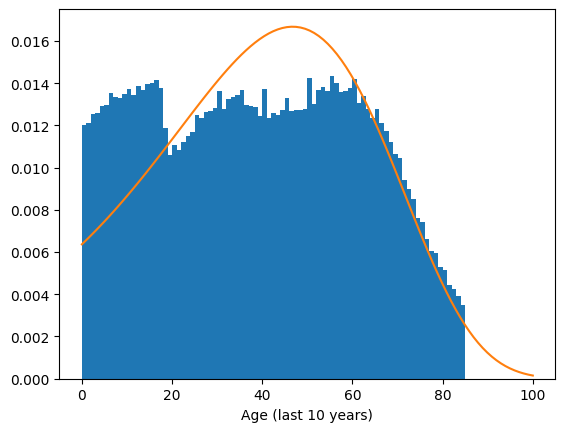

In [45]:
# plot histogram for ages from last 10 years
ages_last10_over18 = np.array(nhis_data["AGE"][nhis_data["YEAR"] >= 2013]).astype(int)
ages_last10_over18 = ages_last10_over18[(ages_last10_over18 < 85) & (ages_last10_over18 >= 0)]
# plot histogram
plt.hist(ages_last10_over18, bins=np.arange(0,np.max(ages_last10_over18)+2,1), density=True)
plt.xlabel("Age (last 10 years)")

# plot skewnorm fit for ages from last 10 years
x = np.linspace(0,100,100)
age_c, age_loc, age_scale = sp.stats.gompertz.fit(ages_last10_over18)
print(age_c, age_loc, age_scale)
p = sp.stats.gompertz.pdf(x, age_c, age_loc, age_scale)
plt.plot(x,p)
plt.show()

# Wait Time Characteristics

In [48]:
"""
430, # TX_DATE
98, # DAYSWAIT_ALLOC
99, # DAYSWAIT_CHRON
"""

kidpan_data["TX_DATE"] = pd.to_datetime(kidpan_data["TX_DATE"].replace(".", np.nan))
kidpan_data["DAYSWAIT_ALLOC"] = kidpan_data["DAYSWAIT_ALLOC"].replace(".", np.nan).astype(float)
kidpan_data["DAYSWAIT_CHRON"] = kidpan_data["DAYSWAIT_CHRON"].replace(".", np.nan).astype(float)

Characterise the waitlist time among those who got transplants

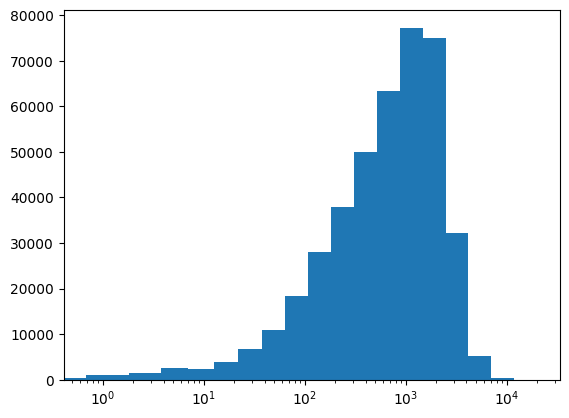

In [70]:
plt.hist(
    kidpan_data["DAYSWAIT_ALLOC"][~np.isnan(kidpan_data["TX_DATE"])],
    bins=np.logspace(0,np.log10(20000),20)-1
)
plt.xscale("log")

(array([6263., 4365., 4305., 3993., 4237., 4174., 4124., 4291., 4038.,
        4496., 3842., 4140., 3841., 3824., 3858., 3473., 3724., 3383.,
        3590., 3304., 3256., 3340., 3034., 3149., 2881., 3052., 2828.,
        2733., 2777., 2594., 2764., 2514., 2603., 2461., 2442., 2419.,
        2346., 2746., 2453., 2579., 2586., 2373., 2441., 2229., 2369.,
        2108., 2276., 2171., 2229., 2132., 2091., 2130., 1975., 2043.,
        1979., 1850., 1983., 1898., 1947., 1828., 1962., 1731., 1807.,
        1834., 1733., 1714., 1660., 1683., 1684., 1681., 1672., 1565.,
        1565., 1865., 1960., 1824., 1866., 1866., 1746., 1861., 1763.,
        1684., 1610., 1669., 1644., 1598., 1613., 1580., 1578., 1523.,
        1560., 1553., 1420., 1506., 1503., 1466., 1388., 1464., 1571.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 3

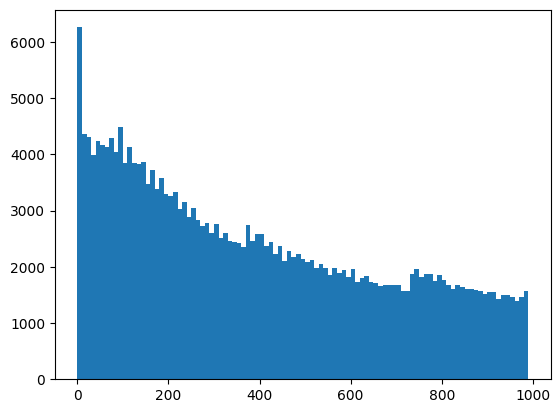

In [76]:
plt.hist(
    kidpan_data["DAYSWAIT_ALLOC"][~np.isnan(kidpan_data["TX_DATE"])],
    bins=np.arange(0,1000,10)
)